In [67]:
import scanpy as sc
import pyturbseq as prtb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

In [138]:
test_data_path = "../tests/data/norman2019_subset_singles.h5ad.gz"
adata = sc.read_h5ad(test_data_path)
print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes")
adata.obs['perturbation'].value_counts()

Loaded 1667 cells and 500 genes


perturbation
KLF1       519
control    500
SET        268
COL2A1     147
SAMD1      120
PTPN12     113
Name: count, dtype: int64

## Convenience functions

### Subsampling and downsampling

Some comparisons (like DEG analysis) are sensitive to the number of cells in the dataset.  
To address this, we can subsample the dataset to a desired number of cells.  


**Note, this function also works in `backed="r"` mode.

In [ ]:
## subsample to specific number
sub1 = prtb.utils.subsample_on_covariate(adata, 'perturbation', num_cells=100)
sub1.obs['perturbation'].value_counts()

perturbation
COL2A1     100
KLF1       100
PTPN12     100
SAMD1      100
SET        100
control    100
Name: count, dtype: int64

In [ ]:
## subsample to minimum
sub1 = prtb.utils.subsample_on_covariate(adata, 'perturbation') #if no num_cells is provided, it will subsample to the minimum number of cells per perturbation
sub1.obs['perturbation'].value_counts()

perturbation
COL2A1     113
KLF1       113
PTPN12     113
SAMD1      113
SET        113
control    113
Name: count, dtype: int64

Additionally, it may be desirable to downsample cell counts within a set of covariates.  

For this, we can use the `subsample_on_multiple_covariates` function. Provide the `min_cols` to specify the columns within which a minimum is taken for the groupby columns. 

In [ ]:
## ensure that, in across each 'gemgroup' there are the same number of perturbations
sub2 = prtb.utils.subsample_on_multiple_covariates(adata, ['perturbation', 'gemgroup'], min_cols=['gemgroup'])
sub2.obs[['perturbation', 'gemgroup']].value_counts().sort_index()

perturbation  gemgroup
COL2A1        1            63
              2            63
KLF1          1           218
              2           218
PTPN12        1            52
              2            52
SAMD1         1            59
              2            59
SET           1           131
              2           131
control       1           224
              2           224
Name: count, dtype: int64

### Backed mode

For large datasets, it is recommended to use `backed="r"` mode. This will allow you to load the anndata object into memory only when needed.
Given the desire to use backed mode, `pyturbseq` filter functions are built to work on anndata objects not yet loaded into memory.

In [97]:
adata_backed = sc.read_h5ad(test_data_path, backed="r")

In [100]:
obs_filters = ['gemgroup == 1', 'perturbation == "control"']

print(f"Before filtering: {adata.shape}")
filtered = prtb.utils.filter_adata(adata, obs_filters=obs_filters)
print(f"After filtering: {filtered.shape}")
filtered.obs[['gemgroup', 'perturbation']].value_counts().sort_index()

Before filtering: (1667, 500)
After filtering: (276, 500)


gemgroup  perturbation
1         control         276
Name: count, dtype: int64

## Psuedobulking

`pyturbseq` provides a convenience pseudobulk wrapper function around the pseuodbulk functionality of (adpbulk)[https://github.com/noamteyssier/adpbulk] by Noam Teyssier.

Pseudobulking is recommended for target change calculations.

In [ ]:
pb = prtb.utils.pseudobulk(adata, groupby=['perturbation']) ## agreggating across gemgroups here
pb.obs.head(2)

Aggregating Samples: 100%|██████████| 12/12 [00:00<00:00, 684.71it/s]


,gemgroup,perturbation
SampleName,,
gemgroup.1-perturbation.COL2A1,1,COL2A1
gemgroup.1-perturbation.KLF1,1,KLF1


## Analysis

In [139]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Target change calculation

By default, target change calculation checks to ensure data is normalized. 

Computing target change for 'perturbation' across 1667 cells...
	Checking if data is normalized to counts per cell...
		Data is not normalized to counts per cell. Normalizing...
	Generating perturbation matrix from 'perturbation' column...
Found 6 unique features.
	Found 5 unique perturbations in perturbation column.
	Computing target change for each cell...


Groups: 100%|██████████| 1/1 [00:00<00:00, 34.51it/s]

Target change calculation done. Storing in AnnData...
	No cells with more than 1 perturbation. Adding metrics to .obs...


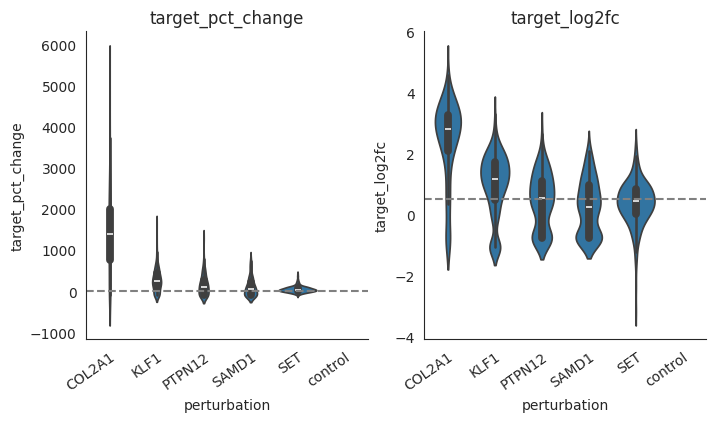

In [40]:
# Calculate target gene changes
prtb.utils.calculate_target_change(adata, perturbation_column='perturbation', control_value='control', delim='_')

target_change_metrics = ['target_pct_change', 'target_log2fc']
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, m in zip(axs, target_change_metrics):
	sns.violinplot(data = adata.obs, x='perturbation', y=m, ax=ax)
	ax.set_xticks(ax.get_xticks())
	ax.set_xticklabels(ax.get_xticklabels(), rotation=35, rotation_mode='anchor', ha='right')
	ax.set_title(m)
	ax.axhline(y=0.5, color='grey', linestyle='--')
plt.show()

Computing target change for 'perturbation' across 1667 cells...
	Checking if data is normalized to counts per cell...
		Data is not normalized to counts per cell. Normalizing...
	Generating perturbation matrix from 'perturbation' column...
Found 6 unique features.
	Found 5 unique perturbations in perturbation column.
	Computing target change for each cell...


Groups: 100%|██████████| 2/2 [00:00<00:00, 34.23it/s]

Target change calculation done. Storing in AnnData...
	No cells with more than 1 perturbation. Adding metrics to .obs...


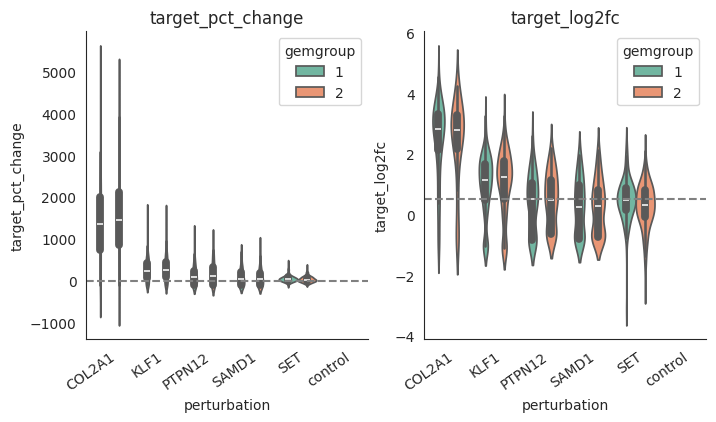

In [42]:
## alternatively, target change can accept a covariate to calculate within group changes
prtb.utils.calculate_target_change(adata, perturbation_column='perturbation', control_value='control', delim='_', groupby='gemgroup')
target_change_metrics = ['target_pct_change', 'target_log2fc']
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, m in zip(axs, target_change_metrics):
	sns.violinplot(data = adata.obs, x='perturbation', y=m, hue='gemgroup', ax=ax, palette='Set2')
	ax.set_xticks(ax.get_xticks())
	ax.set_xticklabels(ax.get_xticklabels(), rotation=35, rotation_mode='anchor', ha='right')
	ax.set_title(m)
	ax.axhline(y=0.5, color='grey', linestyle='--')
plt.show()

### Target change on pseudobulk


It is recommended to calculate target change at the pseudobulk level as sequencing depth drtastically impacts target change estimates for lowly expressed genes. 

In [ ]:
## alternatively, target change can accept a covariate to calculate within group changes
prtb.utils.calculate_target_change(
	pb, perturbation_column='perturbation', control_value='control', delim='_',
	collapse_into_obs=False # here we don't collapse into the obs dataframe but keep the entire target matrix
	)
pb

Computing target change for 'perturbation' across 12 cells...
	Checking if data is normalized to counts per cell...
		Data is not normalized to counts per cell. Normalizing...
	Generating perturbation matrix from 'perturbation' column...
Found 6 unique features.
	Found 5 unique perturbations in perturbation column.
	Computing target change for each cell...


Groups: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]

Target change calculation done. Storing in AnnData...
	'collapse_into_obs' is False. Keeping metrics in .obsm...


AnnData object with n_obs × n_vars = 12 × 500
    obs: np.str_('gemgroup'), np.str_('perturbation')
    obsm: 'perturbation', 'target_pct_change', 'target_log2fc', 'target_zscore', 'target_gene_expression', 'target_reference_mean', 'target_reference_std', 'target_gene'

Calculating target gene heatmap for perturbation column...


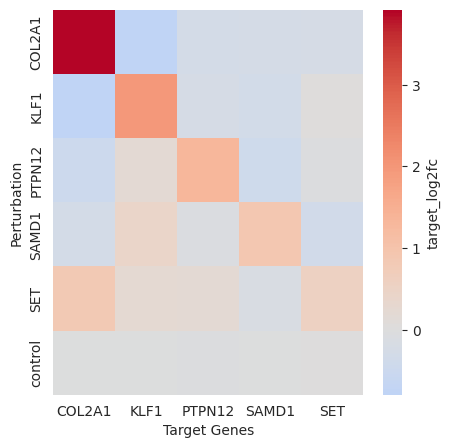

In [53]:
prtb.plot.target_change_heatmap(pb, perturbation_column='perturbation', metric='log2fc', figsize=(5,5))

## Differential expression

We provide wrapper functions for pyDESeq2 to calculate differential expression. It is recommended to perform these also on pseudobulked profiles.

### Single comparison

For a single comparison, we can use the `get_degs` function to calculate differential expression. This assumes that the anndata has been subset to the desired perturbation and control.

In [56]:
## single comparison
# Perform differential expression analysis
# Single comparison: compare specific perturbation vs control
pert = 'COL2A1'
control = 'control'

pb_subset = pb[pb.obs['perturbation'].isin([pert, control])].copy()
pb_subset.obs['perturbation'].value_counts()

perturbation
COL2A1     2
control    2
Name: count, dtype: int64

In [65]:
#Note this test is in a low-sample setting and is only meant for 
degs = prtb.de.get_degs(pb_subset, design_col='perturbation', control_value=control, quiet=True)
print(f"Found {degs['significant'].sum()}/{len(degs)} differentially expressed genes")
degs.head(2)

/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


Found 50/500 differentially expressed genes


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant
AAK1,72.327561,0.014270,0.326309,0.043731,0.965119,0.988972,False
ABI2,98.444809,0.212564,0.289995,0.732990,0.463564,0.799249,False


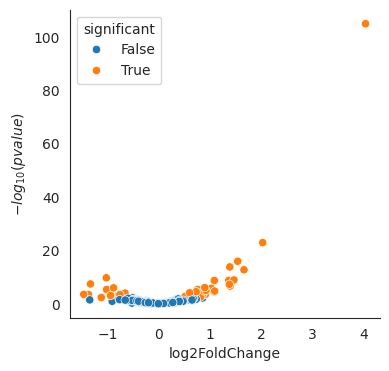

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=degs, x='log2FoldChange', y=-np.log10(degs['pvalue']), hue='significant', ax=ax)
ax.set_ylabel('$-log_{10}(pvalue)$')
plt.show()

### Comparing all perturbations. 

There is also functionality to run pyDESeq2 on all perturbations at once with the `get_all_degs` function.

In [76]:
degs = prtb.de.get_all_degs(pb, design_col='perturbation', control_value=control, quiet=True)
degs.head(2)

/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of f

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,condition
0,AAK1,99.785553,0.187877,0.279942,0.671129,0.502139,0.749431,False,SET
1,ABI2,122.392600,0.102256,0.253034,0.404119,0.686125,0.861966,False,SET


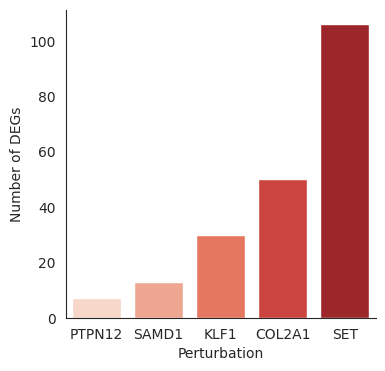

In [79]:
#see number significant
num_degs = degs.groupby('condition')['significant'].sum().sort_values()

fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(x=num_degs.index, y=num_degs.values, ax=ax, hue=num_degs.index, palette='Reds', legend=False)
ax.set_ylabel('Number of DEGs')
ax.set_xlabel('Perturbation')
plt.show()

## Comparing within/across label signal to noise

It can be useful to see if signal from a perturbation is stronger than by some technical covariate (for example gemgroup annotation). To evaluate this, we can calculate an  within and between label similarity using `prtb.utils.calculate_label_similarity` and then evaluate the separability of the label using an auPRC metric with `prtb.utils.get_average_precision_score`.

For example, we see below that perturbation is more separable than gemgroup, indicating signal from the perturbation is stronger than from the gemgroup.

Evaluating labeling similarity using metric: cosine
	Subsampled data to have equal representation of labels. Total cells: 678. Cells per label: 113.0
	Total unique groups: 6
	Total cells: 678
	Subsetting # of across groups to approx. match # of within group comparisons
	Total across group comparisons: 6.0
	Total comparisons: 12
Evaluating labeling similarity using metric: cosine
	Subsampled data to have equal representation of labels. Total cells: 1506. Cells per label: 753.0
	Total unique groups: 2
	Total cells: 1506
	Subsetting # of across groups to approx. match # of within group comparisons
	Total across group comparisons: 1.0
	Total comparisons: 3


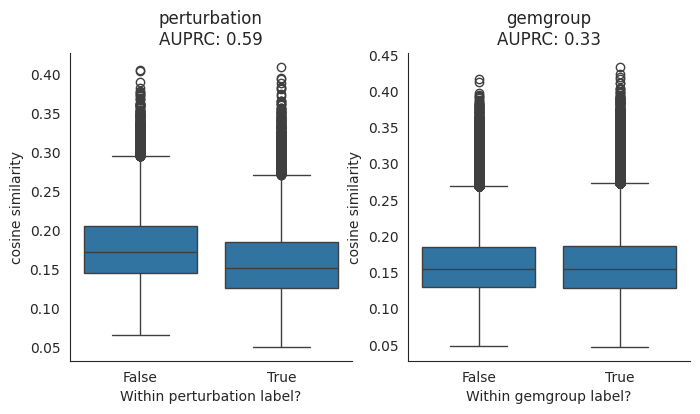

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
metric = 'cosine'

for ax, label in zip(axs, ['perturbation', 'gemgroup']):
	sim = prtb.utils.calculate_label_similarity(adata, label_column=label, metric=metric, verbose=True)
	auprc = prtb.utils.get_average_precision_score(sim)

	sns.boxplot(data=sim, x='within', y='similarity', ax=ax)	
	ax.set_title(f'{label}\nAUPRC: {auprc:.2f}')
	ax.set_xlabel(f'Within {label} label?')
	ax.set_ylabel(f'{metric} similarity')
plt.show()

## E-distance

`pyturbseq` also provides a memory/speed optimized form of e-distance calculation. See scperturb package for more details.

In [140]:
sc.pp.scale(adata)
sc.tl.pca(adata)

/home/aidanw/miniforge3/envs/pyturbseq/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [141]:
edists = prtb.utils.calculate_edistances(adata, obs_key='perturbation', control_value='control',  obsm_key='X_pca')
edists.head()

COL2A1: E-distance = -890.8074
KLF1: E-distance = -824.4840
SET: E-distance = -871.9466
SAMD1: E-distance = -993.6526
PTPN12: E-distance = -852.1985


,perturbation,edistance,n_pert,n_control
0,COL2A1,-890.807410,147,500
1,KLF1,-824.484016,519,500
2,SET,-871.946616,268,500
3,SAMD1,-993.652583,120,500
4,PTPN12,-852.198522,113,500
